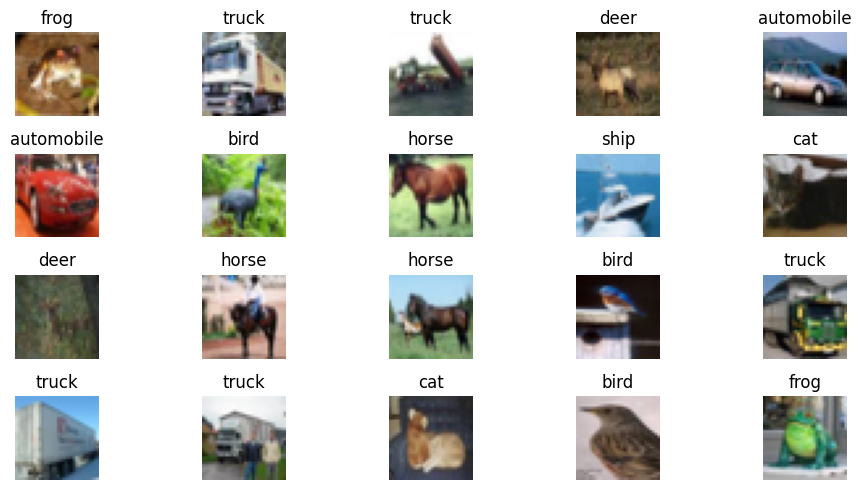

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [1]:
import tensorflow as tf
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


###load the dataset, plot some images samples and flatten+normalize data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

sample_images = X_train[:20]


plt.figure(figsize=(10, 5))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


for i in range(len(sample_images)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(sample_images[i].astype('uint8'))
    plt.title(class_names[int(Y_train[i, 0])])  
    plt.axis('off')  

plt.tight_layout()
plt.show()

# Flatten the images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_train=X_train/255.0
X_test=X_test/255.0

X_train

In [3]:
###data standardization

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

N. of components 90%: 103


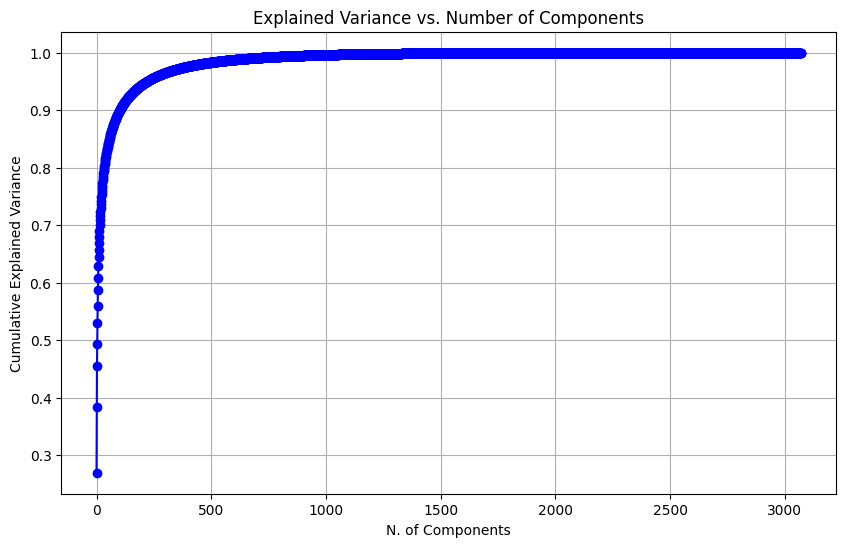

In [5]:
###PCA to calculate n. of principal components of cumulative explained variance (at 90%)

pca = PCA()
pca.fit(X_train_scaled)
explained_variance = pca.explained_variance_ratio_


cumulative_var = np.cumsum(explained_variance)
ncomponents90 = np.argmax(cumulative_var >= 0.90) + 1

print(f"N. of components 90%: {ncomponents90}")


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-', color='b')
plt.xlabel('N. of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [6]:
### the number seems 103 so let's apply it to transform our sets 

num_components = 103  
pca = PCA(n_components=num_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [7]:

X_train_pca=X_train_pca[:50000,:]
Y_train = np.squeeze(Y_train[:50000])
print(Y_train)
print(X_train_pca.shape)
print(Y_train.shape)

[6 9 9 ... 9 1 1]
(50000, 103)
(50000,)


In [8]:
subset_size = 0.2
subset_indices = np.random.choice(X_train_pca.shape[0], size=int(X_train_pca.shape[0] * subset_size), replace=False)
X_train_subset = X_train_pca[subset_indices]
Y_train_subset = Y_train[subset_indices]

svc = svm.SVC()


svc.fit(X_train_subset, Y_train_subset)

# Perform cross-validation using the trained classifier
cv_scores = cross_val_score(svc, X_train_subset, Y_train_subset, cv=5)

mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("CV scores:", cv_scores)
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation : {std_cv_score:.4f}")


CV scores: [0.4685 0.4605 0.469  0.476  0.456 ]
Mean : 0.4660
Standard Deviation : 0.0070


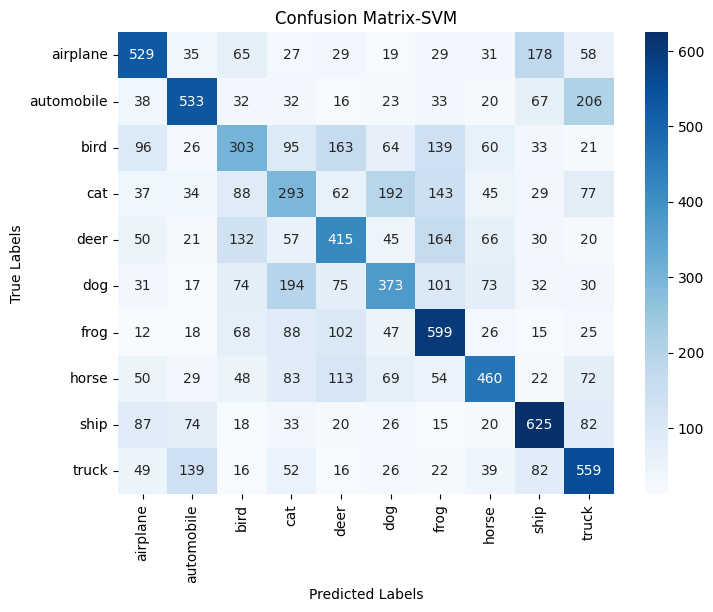

              precision    recall  f1-score   support

    airplane       0.54      0.53      0.53      1000
  automobile       0.58      0.53      0.55      1000
        bird       0.36      0.30      0.33      1000
         cat       0.31      0.29      0.30      1000
        deer       0.41      0.41      0.41      1000
         dog       0.42      0.37      0.40      1000
        frog       0.46      0.60      0.52      1000
       horse       0.55      0.46      0.50      1000
        ship       0.56      0.62      0.59      1000
       truck       0.49      0.56      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



In [9]:
###plotting some useful metrics

Y_pred_svm = svc.predict(X_test_pca)

svmcm = confusion_matrix(Y_test, Y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-SVM')
plt.show()

report = classification_report(Y_test, Y_pred_svm, target_names=class_names)
print(report)

In [10]:
###2nd model:Random Forest classifier

randfor = RandomForestClassifier()
cv_scores = cross_val_score(randfor, X_train_subset, Y_train_subset, cv=5)  
print("CV scores:", cv_scores)

mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


randfor.fit(X_train_subset, Y_train_subset)
Y_pred_randfor = randfor.predict(X_test_pca)

random_forest_score = accuracy_score(Y_test, Y_pred_randfor)
print(f"Accuracy Score on test: {random_forest_score:.4f}")

CV scores: [0.409  0.4205 0.3985 0.422  0.3975]
Mean : 0.4095
Standard Deviation: 0.0104
Accuracy Score on test: 0.4124


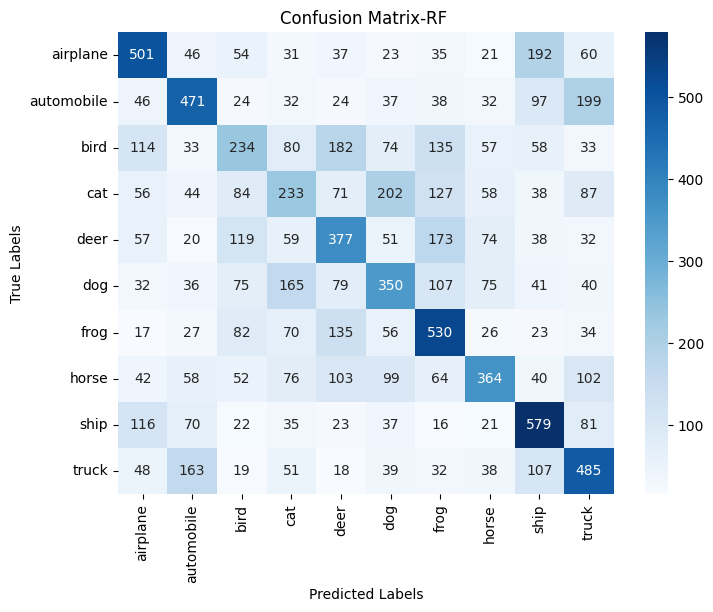

              precision    recall  f1-score   support

    airplane       0.49      0.50      0.49      1000
  automobile       0.49      0.47      0.48      1000
        bird       0.31      0.23      0.27      1000
         cat       0.28      0.23      0.25      1000
        deer       0.36      0.38      0.37      1000
         dog       0.36      0.35      0.36      1000
        frog       0.42      0.53      0.47      1000
       horse       0.48      0.36      0.41      1000
        ship       0.48      0.58      0.52      1000
       truck       0.42      0.48      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000



In [11]:
###random forest metrics

randforcm = confusion_matrix(Y_test, Y_pred_randfor)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-RF ')
plt.show()

report = classification_report(Y_test, Y_pred_randfor, target_names=class_names)
print(report)

In [15]:
###3rd model: logistic regression

logr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

cv_scores = cross_val_score(logr, X_train_subset, Y_train_subset, cv=5)  

mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("CV scores:", cv_scores)
print(f"Mean : {mean_cv_score:.4f}")
print(f"Standard Deviation : {std_cv_score:.4f}")

logr.fit(X_train_subset, Y_train_subset)


Y_pred_logr = logr.predict(X_test_pca)

logistic_regression_score = accuracy_score(Y_test, Y_pred_logr)
print(f"Accuracy Score on test: {logistic_regression_score:.4f}")

CV scores: [0.3765 0.372  0.3835 0.393  0.38  ]
Mean : 0.3810
Standard Deviation : 0.0071
Accuracy Score on test: 0.3827


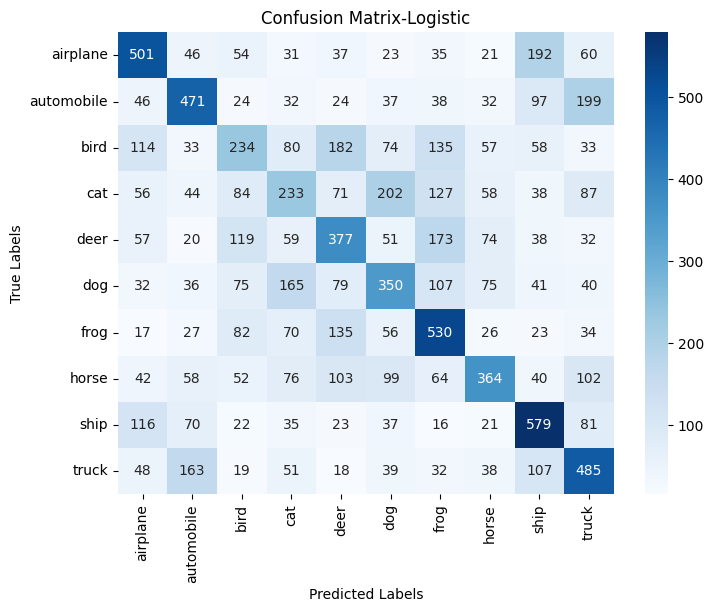

              precision    recall  f1-score   support

    airplane       0.44      0.46      0.45      1000
  automobile       0.48      0.46      0.47      1000
        bird       0.26      0.21      0.23      1000
         cat       0.28      0.25      0.27      1000
        deer       0.34      0.30      0.32      1000
         dog       0.32      0.33      0.32      1000
        frog       0.38      0.48      0.43      1000
       horse       0.43      0.40      0.41      1000
        ship       0.44      0.48      0.46      1000
       truck       0.41      0.46      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000



In [16]:
###metrics for logistic regression
cmlr = confusion_matrix(Y_test, Y_pred_logr)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-Logistic')
plt.show()


report = classification_report(Y_test, Y_pred_logr, target_names=class_names)
print(report)